In [2]:
import cvxopt
from cvxopt import matrix, solvers
from sim3 import vt, dc, ap, qd, RLC, DCS, dcspeed
import numpy as np
import math
import control
import scipy.linalg as linalg
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [3]:
# Compute optimal hidden attack against long memory CUSUM detector
# Input: a system, in [vt(), dc(), ap(), qd(), RLC(), DCS(), dcspeed()]

def long_mem_opt_attack(system):
    
    # General info of the system
    
    start_state = [0] # doens't matter here
    x_ref = np.array([[0]]) # rewritten ref = start_state, hope state keep constant
    
    cusum_thres = np.array([[system.thres]])  # self-defined
    cusum_drift = 0  # can use drift = 0 for now
    
    # control_limit: control signal that guarantees state to reach ref, u_0 term in notes
    # x_{i+1} = A @ x_i + B @ u_i, then u_i = control_limit => x_i = x_{i+1} = x_ref
    # -B^{-1} @ (A-I) @ x_ref = control_limit
    control_limit = 1.667 
    
    # limit_upbound: max control can take, tunable <= max control (first control) under surge attack
    # run surge attack on given cusum_thres and cusum_drift, start from some high upper bound of surge attack
    # then decrease this upper bound until you have attack > upper bound at some time, limit_upbound = upper bound
    limit_upbound = 2.2 
    
    dis_A = np.array(system.sysd.A)
    dis_B = np.array(system.sysd.B)
    con_A = np.array(system.A)
    con_B = np.array(system.B)
    A_dimension = len(dis_A)
    limit_array = np.array([[control_limit]])
    mins = []
    sols = []
    
    # Begin formulate LP problem, treat 100 as infinity in time
    steps = 100
        
    Big_A = -np.eye(A_dimension * steps) # coeffs of vars (states under opt attack at each step)
    Big_B = []  # constant upper bounds of vars
    Obj = [0] * steps
    Q = np.eye(A_dimension)
    R = [[1]]
        
    # Solve CARE for optimal control K backward from infinity horizon
    P = np.matrix(linalg.solve_continuous_are(con_A, con_B, Q, R))
    K = np.matrix(linalg.inv(R) * (con_B.T * P))
        
    # First rows of Big_A: cusum_i <= cusum_threshold for all step i
    print("Preparing cusum constraints of A ...")
    mask = np.tril(np.ones((steps,steps)), -1)
    sub_A = dis_A - dis_B @ K - np.eye(A_dimension) 
    lower_A = np.kron(mask, sub_A)
    Big_A = np.array(Big_A + lower_A)
        
    # Next rows of Big_A: control constraints
    print("Preparing control constraints of A ...")
    control_limit_array = np.zeros((steps,steps))
    for i in range(1, steps):
        control_limit_array[i, i-1] = -(K)[0][0,0]
    Big_A = np.concatenate((Big_A, control_limit_array))
        
    # Final rows of Big_A: absolute value constraint on |est_state - measured_state|
    print("Preparing abs value constraints of A ...")
    attack_limit = np.eye(steps)
    for i in range(1, steps):
        attack_limit[i,i-1] = -(sub_A[0][0,0]+1)
    Big_A = np.concatenate((Big_A,attack_limit))
    
    # For short mem attack, modify Big_B with short_window
    # First rows of Big_B: cusum threshold
    print("Preparing cusum constraints of B ...")
    cusum_thres_term = cusum_thres - (dis_A - dis_B @ K) @ start_state
    cusum_drift_term = cusum_drift - dis_B @ K @ x_ref - dis_B * control_limit
    for i in range(steps):
        this_B =  cusum_thres_term + cusum_drift_term * (i+1)
        for j in range(A_dimension):
            Big_B.append(this_B[j][0,0])
        
    # Next rows of Big_B: control constraints
    print("Preparing control constraints of B ...")
    limit_upbound_term = (limit_upbound - K @ x_ref - limit_array)[0][0,0]
    for i in range(steps):
        Big_B.append(limit_upbound_term)
            
    # Final rows of Big_B: absolute value constraint on |est_state - measured_state|
    print("Preparing abs value constraints of B ...")
    this_B_non_init_term = dis_B @ K @ x_ref + dis_B * control_limit - cusum_drift
    this_B_init_term = this_B_non_init_term + (dis_A - dis_B @ K) @ start_state
    for i in range(steps):
        if i == 0:
            absolute_value_term = this_B_init_term[0][0, 0]
        else:
            absolute_value_term = this_B_non_init_term[0][0, 0]
        Big_B.append(absolute_value_term)
            
    # Solve LP for every step, output solved vars and opt objective
    print("Solving LP for every step ...")
    for i in range(steps):
        # Prepare coeffs in objective
        Obj = [0] * steps
        if i == 0:
            continue
        else:
            for j in range(i, 0, -1): 
                mix1 = -(np.linalg.matrix_power(dis_A, j-1) @ dis_B @ K)
                Obj[i-j] = (mix1[0, :][0, 0])
        # Solve
        sol = solvers.lp(matrix(Obj, (len(Obj), 1), 'd'), matrix(Big_A), matrix(Big_B, (len(Big_B), 1), 'd'), solver='glpk')
        sols.append(list(sol['x']))
        mins.append(sol['primal objective'])
    
    return sols, mins

In [4]:
sols, mins = long_mem_opt_attack(vt())
sols = np.array(sols)
print(sols.shape)

Preparing cusum constraints of A ...
Preparing control constraints of A ...
Preparing abs value constraints of A ...
Preparing cusum constraints of B ...
Preparing control constraints of B ...
Preparing abs value constraints of B ...
Solving LP for every step ...
(99, 100)


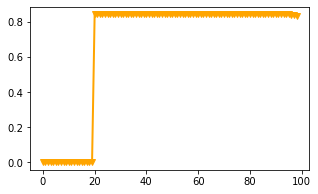

In [6]:
# Column i of sols is the attack trajectory that can cause max deviation of state at time i
x_opt_attack = sols[:, 20]
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.arange(len(x_opt_attack)), x_opt_attack, color = 'Orange', linewidth=2, marker='v')